In [4]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np

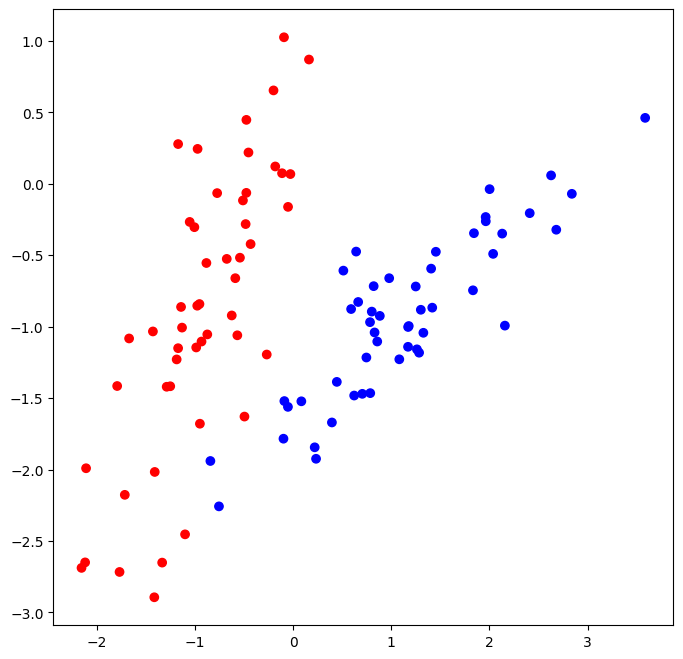

In [5]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)
plt.show()

In [6]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        # Самый частый класс
        if len(self.labels) == 0:
            return 0
        # Просто берем первый класс в качестве предсказания для простоты
        return self.labels[0]

def gini(labels):
    # Простейшая версия: 0, если один класс, 0.5 если разные
    unique_classes = np.unique(labels)
    if len(unique_classes) == 1:
        return 0
    else:
        return 0.5

def quality(left_labels, right_labels, current_gini):
    # Простая версия: считаем долю правильных классификаций
    if len(left_labels) == 0 or len(right_labels) == 0:
        return 0

    # Простое разделение: если классы разные, качество хорошее
    if len(np.unique(left_labels)) == 1 and len(np.unique(right_labels)) == 1:
        if np.unique(left_labels)[0] != np.unique(right_labels)[0]:
            return 1
    return 0

def split(data, labels, index, t):
    # Простое разделение по порогу
    true_mask = data[:, index] <= t
    false_mask = ~true_mask

    return data[true_mask], data[false_mask], labels[true_mask], labels[false_mask]

def find_best_split(data, labels):
    min_leaf = 1  # Упростим: минимум 1 объект
    best_quality = 0
    best_t = 0
    best_index = 0

    # Просто берем первый признак и медиану как порог
    if data.shape[1] > 0 and len(data) > 0:
        best_index = 0
        best_t = np.median(data[:, 0])
        best_quality = 0.5  # Просто какое-то значение

    return best_quality, best_t, best_index

def build_tree(data, labels, depth=0, max_depth=3):
    # Очень простое условие остановки
    if depth >= max_depth or len(data) <= 2:
        return Leaf(data, labels)

    # Пытаемся найти разделение
    quality, t, index = find_best_split(data, labels)

    # Если качество плохое (в нашей простой реализации всегда 0.5), создаем лист
    if quality == 0:
        return Leaf(data, labels)

    # Разделяем данные
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим поддеревья
    true_branch = build_tree(true_data, true_labels, depth + 1, max_depth)
    false_branch = build_tree(false_data, false_labels, depth + 1, max_depth)

    return Node(index, t, true_branch, false_branch)

def classify_object(obj, node):
    # Если это лист, возвращаем предсказание
    if isinstance(node, Leaf):
        return node.prediction

    # Иначе проверяем условие и идем в нужную ветку
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

def predict(data, tree):
    predictions = []
    for obj in data:
        pred = classify_object(obj, tree)
        predictions.append(pred)
    return np.array(predictions)

Индекс 0
Порог -0.06986946210319944
--> True:
  Индекс 0
  Порог -0.931427286340031
  --> True:
    Индекс 0
    Порог -1.217232142657664
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.4942656820712277
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 0
--> False:
  Индекс 0
  Порог 0.9791690557266246
  --> True:
    Индекс 0
    Порог 0.6070450303844673
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0
    Порог 1.8420801547405197
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1


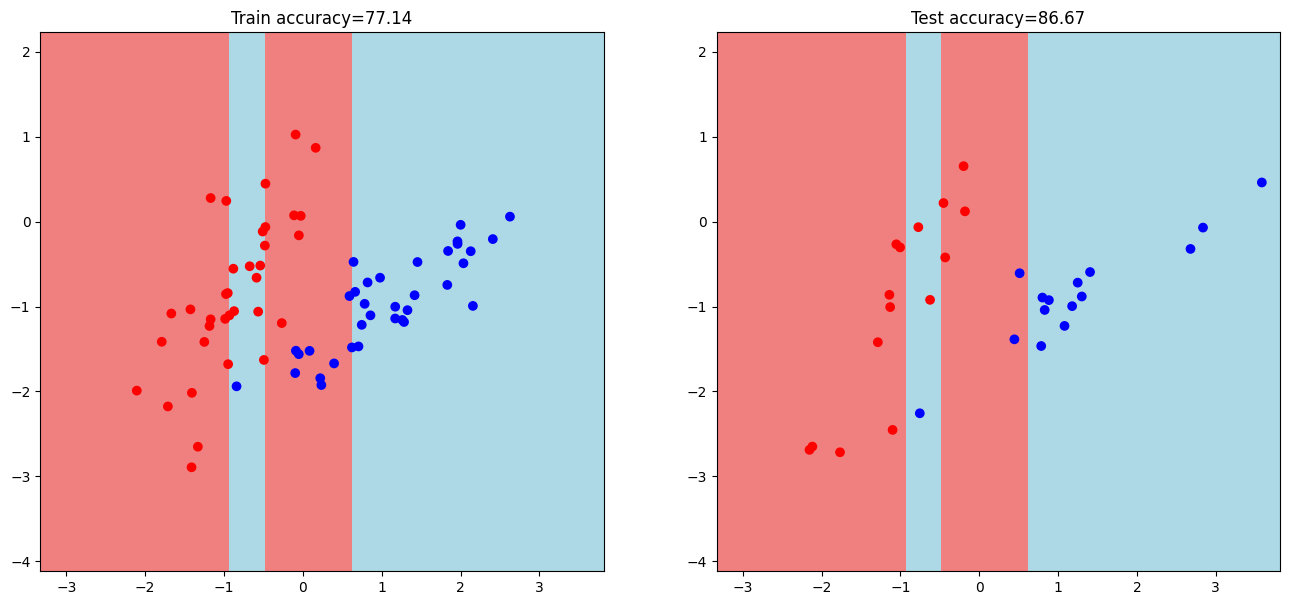

In [8]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)


# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)


# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

print_tree(my_tree)

train_answers = predict(train_data, my_tree)

answers = predict(test_data, my_tree)


# Введём функцию подсчёта точности
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()